# Sparse recovery using $\ell_{1/2}$ norm

The aim is to recover a sparse nonnegative signal $x_0 \in \mathbb{R}^n$ from a 
measurement vector $y = A x_0$, where $A \in \mathbb{R}^{m \times n}$ (with $m < n$) is 
a known sensing matrix. A common heuristic based on convex optimization is to minimize 
the $\ell_1$ norm of $x$ (which reduces here to the sum of entries of $x$) subject to 
$y = Ax_0$ (and here, $x \geq 0$).  

It has been proposed to minimize the sum of the \textit{square roots} of the entries of 
$x$, which since $x \geq 0$ is the same as minimizing the square root of the 
$\ell_{1/2}$ 'norm' (which is not convex, and therefore not a norm), to obtain better 
recovery. 

The optimization problem is

$$
\begin{array}{ll}
\text{minimize}   & \displaystyle \sum_{i=1}^n \sqrt{x_i} \\
\text{subject to} & y = Ax,
\end{array}
$$

where $x$ is the variable. (The constraint $x \geq 0$ is implicit, since this is the 
objective domain.)  This is a nonconvex problem, directly in DCCP form.


In a numerical simulation, we take $n=100$, $A_{ij} \sim \mathcal{N}(0,1)$, 
the positions of the nonzero entries in $x_0$ are from uniform distribution, 
and the nonzero values are the absolute values of $\mathcal{N}(0,100)$ random variables.  

To count the probability of recovery, 100 independent instances are tested, 
and a recovery is successful if the relative error 

$$
\frac{\|\hat{x} - x_0\|_2}{\|x_0\|_2}
$$

is less than 0.01.  

In each instance, the cardinality takes 6 values from 30 to 50, according to which $x_0$ 
is generated, and $A$ is generated for each $m$ taking one of the 6 values from 50 to 
80. The results in figure 5 verify that nonconvex recovery is more effective than convex 
recovery.

<!-- Currently, this example doesnt work well. I suspect it's because of an issue with
damping where sometimes multiple damping steps are required, but we only do one. -->

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

from dccp import is_dccp

rng = np.random.default_rng()

n = 100
m = [50, 56, 62, 68, 74, 80]
k = [30, 34, 38, 42, 46, 50]
T = 5

proba = np.zeros((len(m), len(k)))
proba_l1 = np.zeros((len(m), len(k)))

for time in range(T):
    for kk in k:
        x0 = np.zeros((n, 1))
        ind = rng.permutation(n)
        ind = ind[0:kk]
        x0[ind] = rng.standard_normal((kk, 1)) * 10
        x0 = np.abs(x0)

        for mm in m:
            A = rng.standard_normal((mm, n))
            y = np.dot(A, x0)

            # sqrt of 0.5-norm minimization
            x_pos = cp.Variable(shape=((n, 1)), nonneg=True)
            cost = cp.reshape(cp.sum(cp.sqrt(x_pos), axis=0), (1, 1), order="F")
            prob = cp.Problem(cp.Minimize(cost), [A @ x_pos == y])

            # initialize variable value before solving
            x_pos.value = np.ones((n, 1))
            assert is_dccp(prob)
            
            # try different solvers in case one fails
            result = None
            for solver in ["ECOS", "SCS"]:
                try:
                    result = prob.solve(method="dccp", solver=solver, seed=0)
                    break
                except Exception as e:
                    continue
            
            if result is None:
                print("All solvers failed")
                x_pos.value = None

            if (
                x_pos.value is not None
                and cp.pnorm(x_pos - x0, 2).value / cp.pnorm(x0, 2).value <= 1e-2
            ):
                indm = m.index(mm)
                indk = k.index(kk)
                proba[indm, indk] += 1 / float(T)

            # l1 minimization
            xl1 = cp.Variable((n, 1))
            cost_l1 = cp.pnorm(xl1, 1)
            obj = cp.Minimize(cost_l1)
            constr = [A @ xl1 == y]
            prob_l1 = cp.Problem(obj, constr)
            result_l1 = prob_l1.solve()

            if cp.pnorm(xl1 - x0, 2).value / cp.pnorm(x0, 2).value <= 1e-2:
                indm = m.index(mm)
                indk = k.index(kk)
                proba_l1[indm, indk] += 1 / float(T)

            if x_pos.value is not None:
                print(
                    "time=",
                    time,
                    "k=",
                    kk,
                    "m=",
                    mm,
                    "relative error = ",
                    cp.pnorm(x_pos - x0, 2).value / cp.pnorm(x0, 2).value,
                )
            else:
                print("time=", time, "k=", kk, "m=", mm, "relative error = ", 1.0)
            print(
                f"time={time}, kk={kk}, mm={mm}, l1 relative error = {
                    cp.pnorm(xl1 - x0, 2).value / cp.pnorm(x0, 2).value
                }"
            )

time= 0 k= 30 m= 50 relative error =  5.320765357483703e-16
time=0, kk=30, mm=50, l1 relative error = 0.5900381662029932
time= 0 k= 30 m= 56 relative error =  5.949929515439611e-16
time=0, kk=30, mm=56, l1 relative error = 0.26559450550336683
time= 0 k= 30 m= 62 relative error =  1.1636763051953711e-15
time=0, kk=30, mm=62, l1 relative error = 9.453354178807078e-08
time= 0 k= 30 m= 62 relative error =  1.1636763051953711e-15
time=0, kk=30, mm=62, l1 relative error = 9.453354178807078e-08
time= 0 k= 30 m= 68 relative error =  7.215809854961688e-16
time=0, kk=30, mm=68, l1 relative error = 4.558491408765005e-09
time= 0 k= 30 m= 68 relative error =  7.215809854961688e-16
time=0, kk=30, mm=68, l1 relative error = 4.558491408765005e-09
time= 0 k= 30 m= 74 relative error =  4.242616482553065e-16
time=0, kk=30, mm=74, l1 relative error = 1.566012645491372e-09
time= 0 k= 30 m= 74 relative error =  4.242616482553065e-16
time=0, kk=30, mm=74, l1 relative error = 1.566012645491372e-09
time= 0 k= 

/home/langestefan/dev/cvx/dccp/.venv/lib64/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


All solvers failed
time= 1 k= 34 m= 50 relative error =  1.0
time=1, kk=34, mm=50, l1 relative error = 0.34837823090680303
time= 1 k= 34 m= 56 relative error =  9.938026573151879e-14
time=1, kk=34, mm=56, l1 relative error = 0.4555864653925443
time= 1 k= 34 m= 56 relative error =  9.938026573151879e-14
time=1, kk=34, mm=56, l1 relative error = 0.4555864653925443
All solvers failed
time= 1 k= 34 m= 62 relative error =  1.0
time=1, kk=34, mm=62, l1 relative error = 0.2854582074530168
All solvers failed
time= 1 k= 34 m= 62 relative error =  1.0
time=1, kk=34, mm=62, l1 relative error = 0.2854582074530168
All solvers failed
time= 1 k= 34 m= 68 relative error =  1.0
time=1, kk=34, mm=68, l1 relative error = 0.049346379319755274
All solvers failed
time= 1 k= 34 m= 68 relative error =  1.0
time=1, kk=34, mm=68, l1 relative error = 0.049346379319755274
All solvers failed
time= 1 k= 34 m= 74 relative error =  1.0
time=1, kk=34, mm=74, l1 relative error = 7.610605280714591e-09
All solvers failed

## Visualize result

Text(0.5, 1.0, 'probability of recovery')

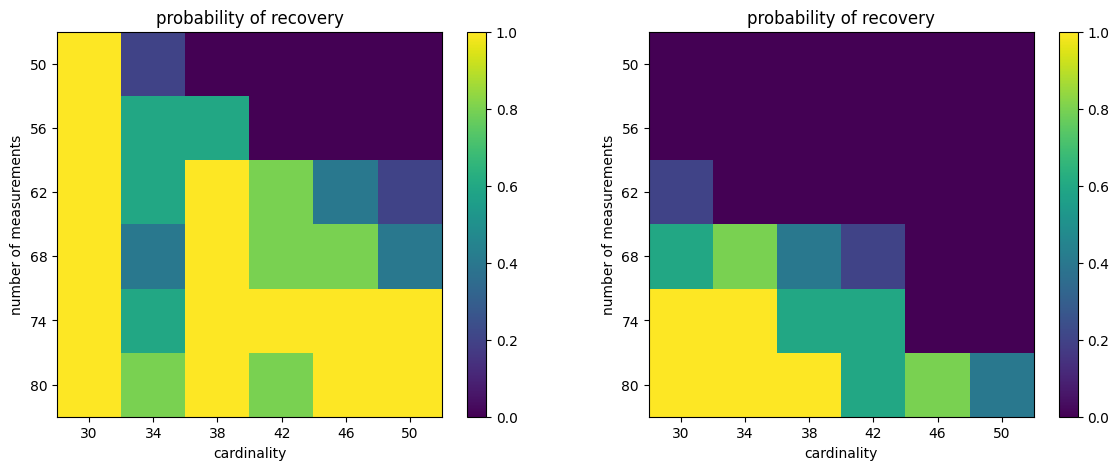

In [4]:
fig = plt.figure(figsize=[14, 5])
ax = plt.subplot(1, 2, 1)

plt.xticks(range(0, len(k)), k)
plt.xlabel("cardinality")
plt.yticks(range(0, len(m)), m)
plt.ylabel("number of measurements")

a = ax.imshow(proba, interpolation="none")
fig.colorbar(a)
ax.set_title("probability of recovery")
ax = plt.subplot(1, 2, 2)
b = ax.imshow(proba_l1, interpolation="none")
fig.colorbar(b)
plt.xticks(range(0, len(k)), k)
plt.xlabel("cardinality")
plt.yticks(range(0, len(m)), m)
plt.ylabel("number of measurements")
ax.set_title("probability of recovery")